## Notebook to explore changes in polysemanticity as training time increases

Models assessed: 
- simple ReLU S=0.99
- ReLU_Plus_X S=0.99

Number of training steps: [1000, 10000, 80000, 160000]

Metrics to explore: 
- Loss (MSE) with input at S = 0.99
- Loss (MSE) at lower sparsity points: S = [0.2, 0.4, 0.6, 0.8, 0.9]
- Distribution of feature weights per neuron
- Distribution of neuron weights per feature
- Number of features per neuron
- Number of monosemantic neurons (if any)

In [2]:
"""Notebook settings and imports."""

%load_ext autoreload
%autoreload 2
# %flow mode reactive

import os

from dataclasses import dataclass, field
from typing import Callable, List, Optional, Tuple, Union

import matplotlib as mpl
import numpy as np
import pandas as pd
import torch as t
import matplotlib.pyplot as plt

from einops import asnumpy, einsum, rearrange, reduce, repeat, pack, parse_shape, unpack
from einops.layers.torch import Rearrange, Reduce
from jaxtyping import Float, Int
from matplotlib import pyplot as plt
from plotly import express as px
from plotly import graph_objects as go
from plotly import io as pio
from rich import print as rprint
import seaborn as sns
from torch import nn, optim, Tensor
from torch.nn import functional as F
from tqdm.notebook import tqdm

from toy_cis.models import CisConfig, Cis
from toy_cis.plot import plot_weight_bars, plot_input_output_response
from toy_cis.util import threshold_matrix, in_out_response


In [3]:
"""Set KMP_DUPLICATE_LIB_OK=TRUE to avoid MKL errors when plotting with mpl"""

os.environ["KMP_DUPLICATE_LIB_OK"] = "True"
plt.rcParams.update({"font.size": 16})

In [4]:
"""Set torch device."""

device = t.device("cuda" if t.cuda.is_available() else "cpu")
# device = t.device("cpu")  # small toy models have lower loss and are faster via cpu
device_name = t.cuda.get_device_name(0) if t.cuda.is_available() else "cpu"
print(f"{device_name=}")

device_name='NVIDIA A40'


## 1. Simple ReLU

MLP that computes: $y = ReLU(x)$

Linear map with 50 neurons: 

$$
h = ReLU(W_1x) \\
y' = W_2h
$$

Input: 100 features with a varying sparsity levels, meaning that any given feature has p = 0.01 of being active, where `x = rand(-1,1)`

Loss function: MSE (not weighted for now)

$$
\text{MSE} = \frac{1}{N} \sum_{i=1}^{N} \left(y_i - y_{\text{true},i}\right)^2 \\[2ex]
$$

In [27]:
# 1. Training functions
"""Create functions for generating batches, loss, and training."""

def gen_batch(model: Cis, batch_sz: int, sparsity: float | Float[Tensor, "inst feat"]) -> (
    tuple[Float[Tensor, "batch inst feat"], Float[Tensor, "batch inst feat"]]
):
    """Generates a batch of x, y data."""
    # Randomly generate features vals, and for each, randomly set which samples are non-zero
    x = t.rand(batch_sz, model.cfg.n_instances, model.cfg.n_feat, device=device) * 2 - 1  # [-1, 1]
    is_active = (
        t.rand(batch_sz, model.cfg.n_instances, model.cfg.n_feat, device=device) < (1 - sparsity)
    )
    x *= is_active
    return x, t.relu(x)

def gen_batch_sparse(model: Cis, batch_sz: int, sparsity: float | Float[Tensor, "inst feat"]) -> (
    tuple[Float[Tensor, "batch inst feat"], Float[Tensor, "batch inst feat"]]
):
    """Generates a batch of x, y data."""
    # Randomly generate features vals, and for each, randomly set which samples are non-zero
    x = t.rand(batch_sz, model.cfg.n_instances, model.cfg.n_feat, device=device) * 2 - 1  # [-1, 1]
    is_active = (
        t.rand(batch_sz, model.cfg.n_instances, model.cfg.n_feat, device=device) < (1 - sparsity)
    )
    x *= is_active
    return x, t.relu(x)

def loss_fn(y, y_true, i):
    return reduce((y - y_true) ** 2 * i, "batch inst feat -> ", "mean")

def train(
    model: Cis,
    batch_sz: int,
    feat_sparsity: float | Float[Tensor, "inst feat"],
    feat_importance: float | Float[Tensor, "inst feat"],
    loss_fn: Callable,
    optimizer: optim.Optimizer,
    n_steps: int,
    logging_freq: int,
) -> List[Float]:
    """Trains the model for `n_steps` steps, logging loss every `logging_freq` steps."""    
    losses = []

    pbar = tqdm(range(n_steps), desc="Training")
    for step in pbar:
        x, y_true = gen_batch(model, batch_sz, feat_sparsity)
        y = model.forward(x)
        loss = loss_fn(y, y_true, feat_importance)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        # Log progress
        if step % logging_freq == 0 or (step + 1 == n_steps):
            losses.append(loss.item())
            pbar.set_postfix({"loss": f"{loss.item():.4f}"})
    
    return losses

Training:   0%|          | 0/1000 [00:00<?, ?it/s]

Testing over sparsities:   0%|          | 0/6 [00:00<?, ?it/s]

W.shape=torch.Size([50, 100])


Training:   0%|          | 0/10000 [00:00<?, ?it/s]

Testing over sparsities:   0%|          | 0/6 [00:00<?, ?it/s]

W.shape=torch.Size([50, 100])


Training:   0%|          | 0/80000 [00:00<?, ?it/s]

Testing over sparsities:   0%|          | 0/6 [00:00<?, ?it/s]

W.shape=torch.Size([50, 100])


Training:   0%|          | 0/160000 [00:00<?, ?it/s]

Testing over sparsities:   0%|          | 0/6 [00:00<?, ?it/s]

W.shape=torch.Size([50, 100])


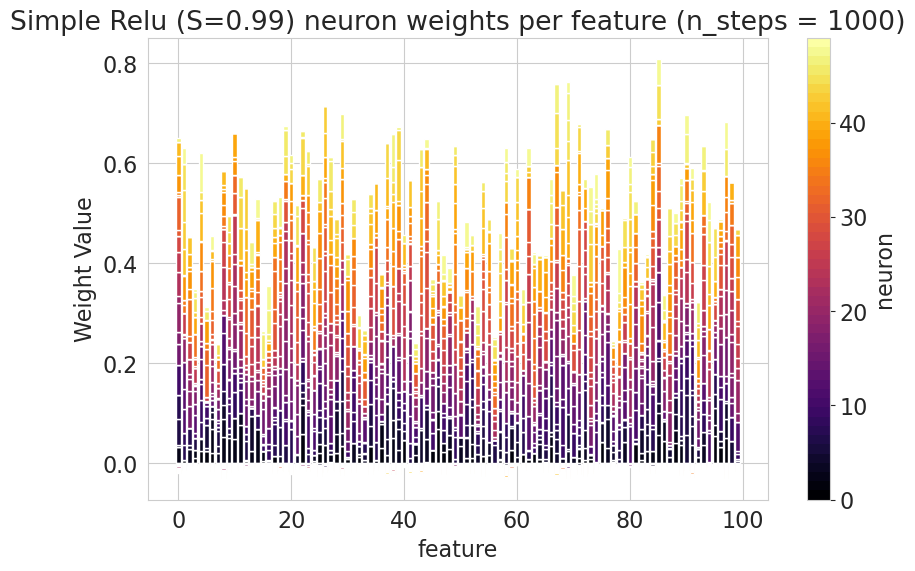

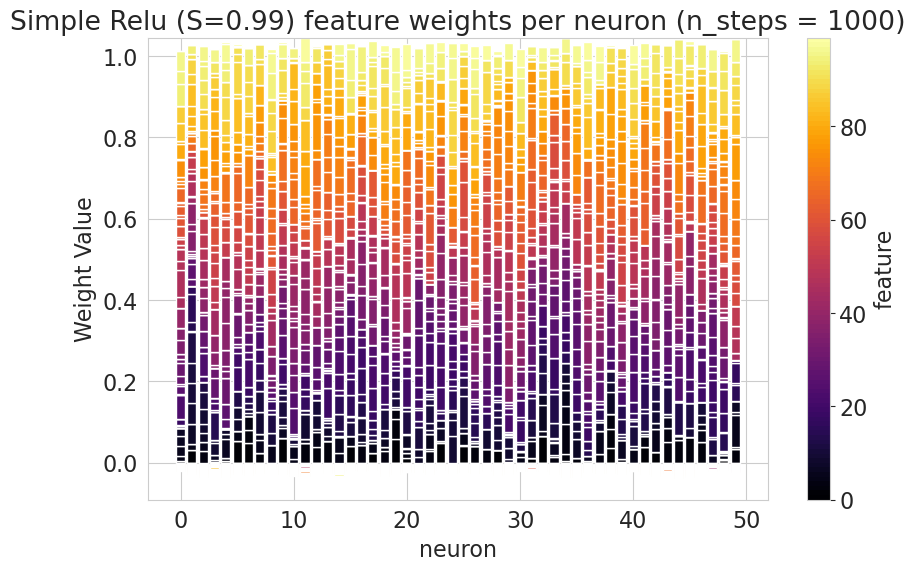

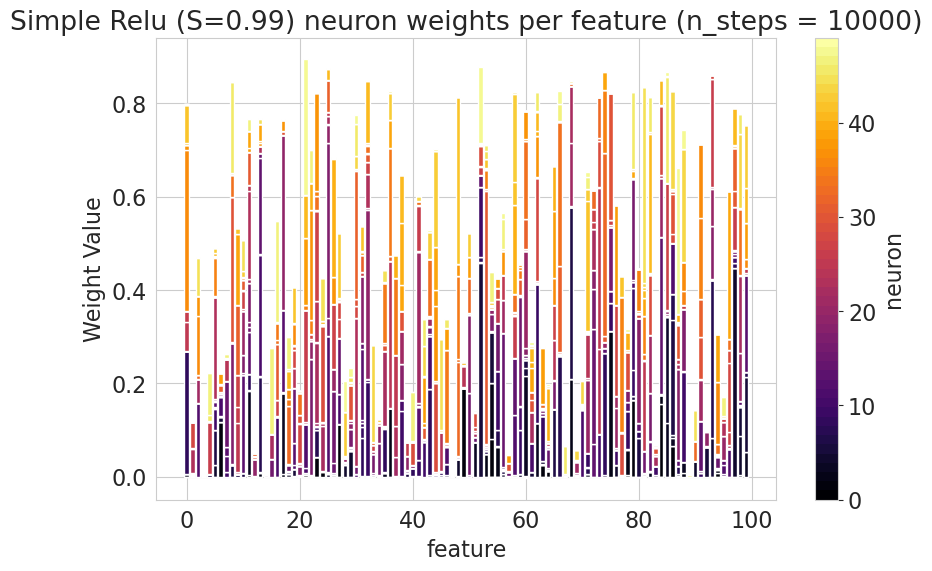

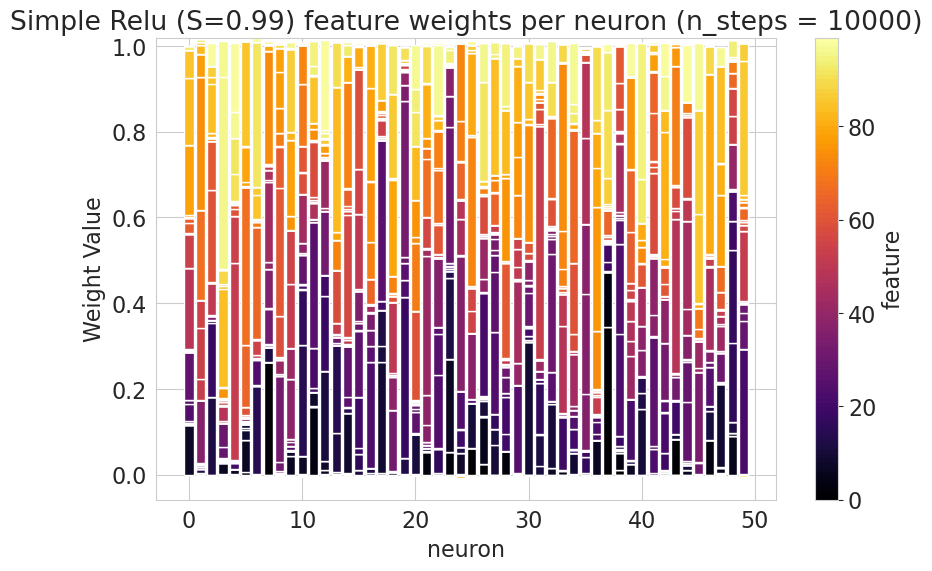

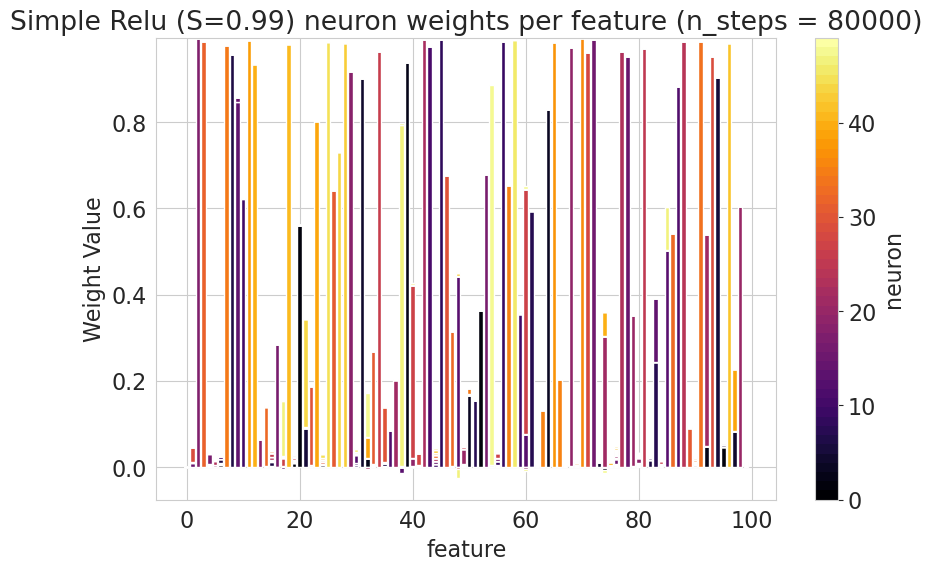

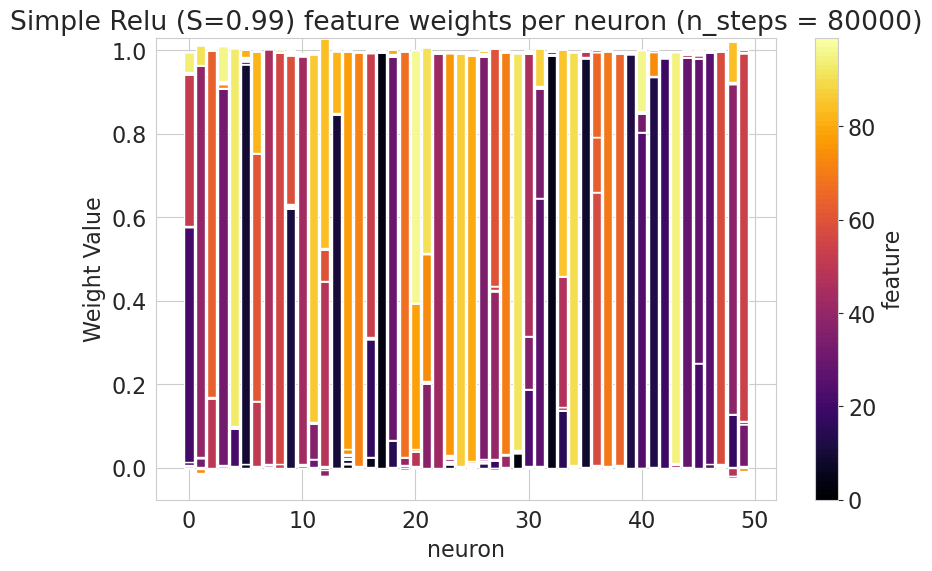

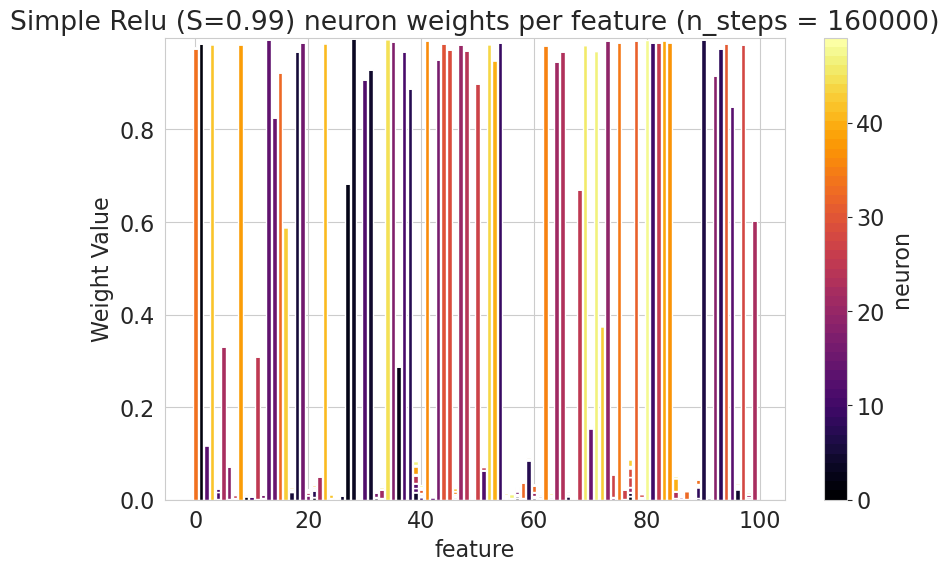

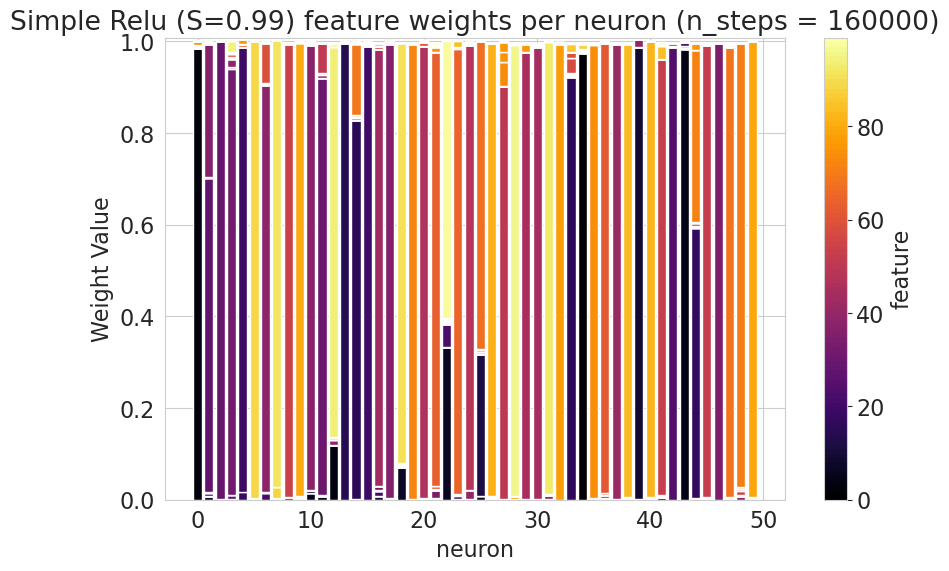

In [28]:
"""1. Define SIMPLE RELU MODEL - 100 FEATURES, 50 NEURONS"""
layer_act_fns = [t.relu, lambda x: x]

simple_relu_cfg = CisConfig(
    n_instances=1,
    n_feat=100,
    n_hidden=50,
    act_fn=layer_act_fns,
    b1=None,
    b2=None,
)

"""Train a ReLU at S=0.99 and assess performance at different sparsity levels"""
loss_data_simpleRelu99 = []
poly_data_simpleRelu99 = []
steps_list = [1000, 10000, 80000, 160000]

for n_steps in steps_list: 
    
    # 1. Train the simple ReLU model on S=0.99 input for a given number of steps
    if 'relu_cis' in locals() or 'relu_cis' in globals():
        del relu_cis
        
    relu_cis = Cis(simple_relu_cfg, device=device)
    
    batch_sz = 256
    feat_sparsity = 0.99
    feat_importance = 1
    logging_freq = n_steps // 100
    optimizer = t.optim.Adam(relu_cis.parameters())
    
    losses = train(
        relu_cis,
        batch_sz,
        feat_sparsity,
        feat_importance,
        loss_fn,
        optimizer,
        n_steps,
        logging_freq
    )

    # 2. Test performance at different sparsity levels
    sparsities = [0.2, 0.4, 0.6, 0.8, 0.9, 0.99]
    batch_sz = 256
    feat_importance = 1
    logging_freq = n_steps // 10
    
    pbar = tqdm(sparsities, desc="Testing over sparsities")
    n_examples = 200
    
    for s in pbar:
        
        with t.no_grad():
            # generate examples of inputs
            x, y_true = gen_batch(relu_cis, n_examples, s)
            
            # compute mean loss
            y = relu_cis.forward(x)
            active_weight, inactive_weight = 10, 1
            weights = t.where(y_true == 1, active_weight, inactive_weight)
            loss = weights * (y - y_true) ** 2
            
            # store loss at sparsity level
            loss = rearrange(loss, "examples 1 features -> examples features")
            loss = asnumpy(reduce(loss, "examples features -> features", "mean"))
            for feat_idx, val in enumerate(loss):
                loss_data_simpleRelu99.append({"steps": n_steps, "sparsity": s, "feature_idx": feat_idx, "loss_per_feature": val})

    # 3. Plot weights per neuron and per feature
    """Plot weights for neurons per feature, and for features per neuron."""

    W = einsum(relu_cis.W1, relu_cis.W2, "inst neuron feature, inst feature neuron-> neuron feature")
    W = threshold_matrix(W.squeeze(), threshold=0.001)
    
    print(f"{W.shape=}")
    
    fig = plot_weight_bars(W, xax="feature")
    fig.get_axes()[0].set_title(r"Simple Relu (S=0.99) neuron weights per feature (n_steps = {})".format(n_steps))
    fig.savefig(f"/workspace/S=099Relu_weightsPerFeature_nSteps{n_steps}.png", dpi = 300)
    
    fig = plot_weight_bars(W.T, xax="neuron")
    fig.get_axes()[0].set_title(r"Simple Relu (S=0.99) feature weights per neuron (n_steps = {})".format(n_steps))
    fig.savefig(f"/workspace/S=099Relu_weightsPerNeuron_nSteps{n_steps}.png", dpi = 300)

    # 4. Compute number of features per neuron and number of monosemantic neurons and store
    features_per_neuron = np.sum(W.cpu().detach().numpy() > 0.001, axis= 1)
    monosemantic_neurons = np.sum(features_per_neuron == 1)
    poly_data_simpleRelu99.append({"steps": n_steps, "features_per_neuron": features_per_neuron, "monosemantic_neurons": monosemantic_neurons})
    

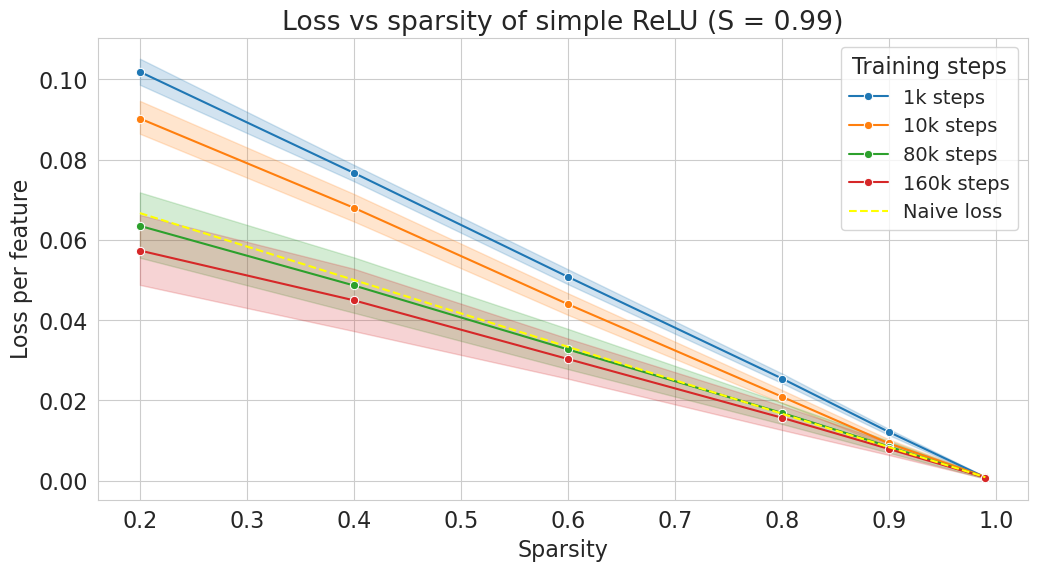

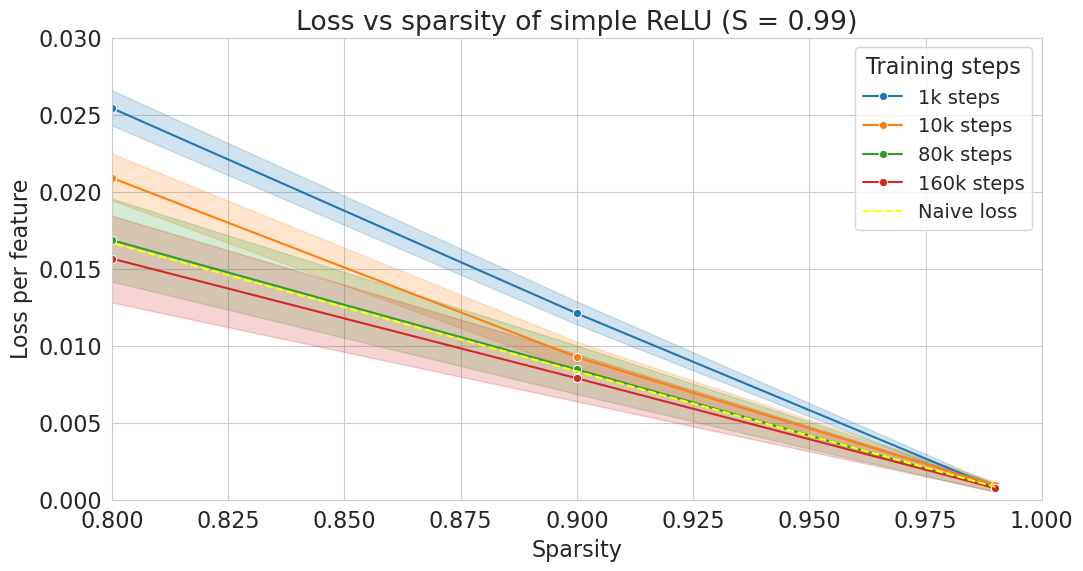

In [44]:
## Plot performance at various sparsity levels vs number of steps during training

df = pd.DataFrame.from_dict(loss_data_simpleRelu99, orient="columns")
dfs = {group: df[df["steps"] == group].drop(columns="steps") for group in df["steps"]}

df_1k = dfs[1000]
df_10k = dfs[10000]
df_80k = dfs[80000]
df_160k = dfs[160000]

# Add a column to track the origin of each DataFrame
df_1k['source'] = '1k steps'
df_10k['source'] = '10k steps'
df_80k['source'] = '80k steps'
df_160k['source'] = '160k steps'

# Combine all DataFrames
df_combined = pd.concat([df_1k, df_10k, df_80k, df_160k])

# Plot
plt.figure(figsize=(12, 6))
sns.lineplot(data=df_combined, x='sparsity', y = "loss_per_feature", hue='source', marker='o')

# add naive loss
naive_loss = 0.5 * (1 - np.array(sparsities)) / 6
plt.plot(sparsities, naive_loss.ravel(), linestyle="dashed", color="yellow", label=r"Naive loss")

# Customize legend
plt.legend(title="Training steps", fontsize = 14)

# Labels & Title
plt.xlabel("Sparsity")
plt.ylabel("Loss per feature")
plt.title("Loss vs sparsity of simple ReLU (S = 0.99)")

# Save and show plot
plt.savefig("/workspace/simpleReLU_S=099_loss_numberSteps.png", dpi=300)
plt.show()

# Plot
plt.figure(figsize=(12, 6))
sns.lineplot(data=df_combined, x='sparsity', y = "loss_per_feature", hue='source', marker='o')

# add naive loss
naive_loss = 0.5 * (1 - np.array(sparsities)) / 6
plt.plot(sparsities, naive_loss.ravel(), linestyle="dashed", color="yellow", label=r"Naive loss")

# Customize legend
plt.legend(title="Training steps", fontsize = 14)

# Labels & Title
plt.xlim(0.8,1.0)
plt.ylim(0,0.03)
plt.xlabel("Sparsity")
plt.ylabel("Loss per feature")
plt.title("Loss vs sparsity of simple ReLU (S = 0.99)")

# Save and show plot
plt.savefig("/workspace/simpleReLU_S=099_loss_numberSteps_highS.png", dpi=300)
plt.show()

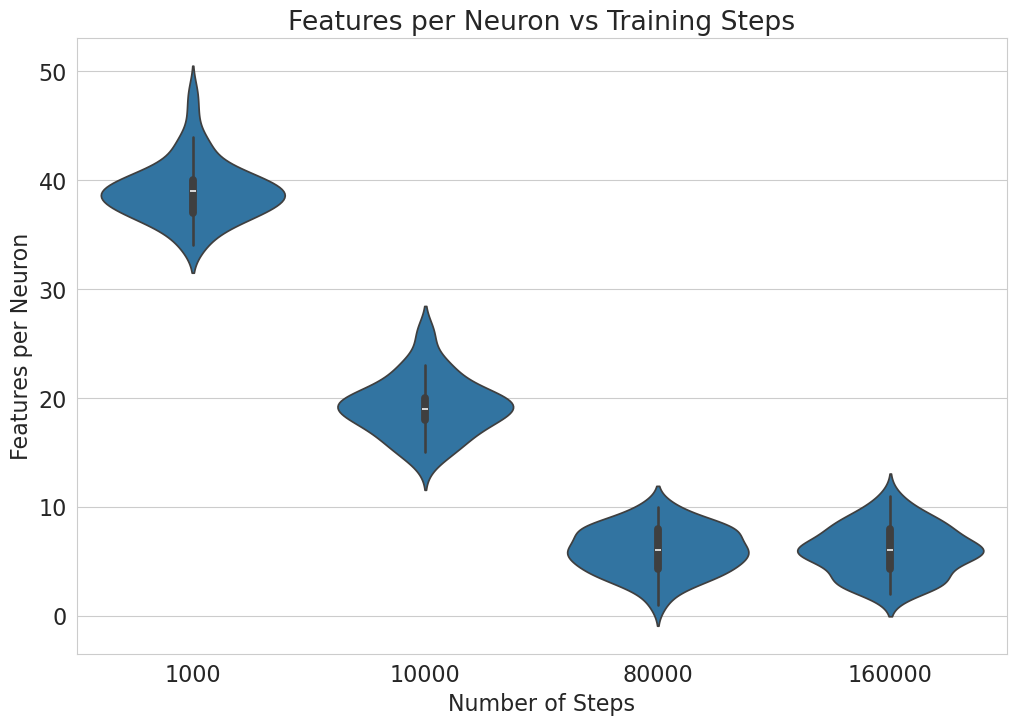

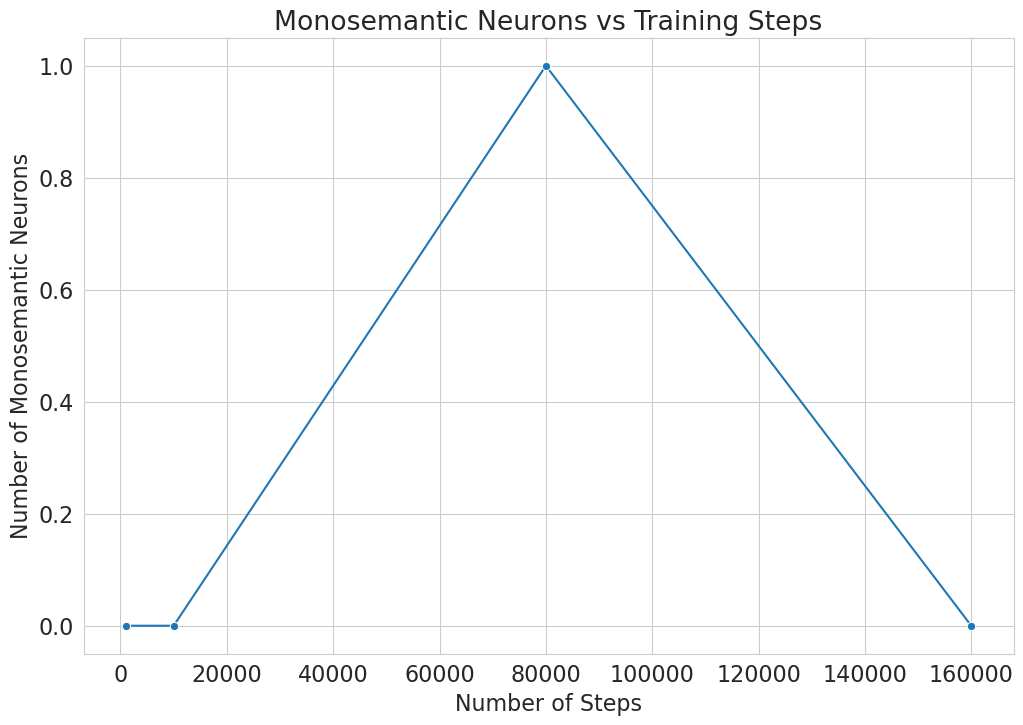

In [29]:

# Plot feature per neuron and number of monosemantic neurons across training steps

poly_data = pd.DataFrame(poly_data_simpleRelu99)

# Expand lists into separate rows, replicating 'steps' for each
poly_data_df = poly_data.explode("features_per_neuron")

# Convert 'features_per_neuron' to float
poly_data_df["features_per_neuron"] = poly_data_df["features_per_neuron"].astype(float)

plt.figure(figsize=(12,8))
sns.violinplot(data=poly_data_df, x="steps", y="features_per_neuron")

# Labels and title
plt.xlabel("Number of Steps")
plt.ylabel("Features per Neuron")
plt.title("Features per Neuron vs Training Steps")

plt.savefig("/workspace/simpleReLUS=099_featuresPerNeuron_trainingSteps.png", dpi=300)
plt.show()

# Expand lists into separate rows, replicating 'steps' for each
poly_data_df = poly_data.explode("monosemantic_neurons")

# Convert 'features_per_neuron' to float
poly_data_df["monosemantic_neurons"] = poly_data_df["monosemantic_neurons"].astype(float)

plt.figure(figsize=(12,8))
sns.lineplot(data=poly_data, x="steps", y="monosemantic_neurons", marker="o")

# Labels and title
plt.xlabel("Number of Steps")
plt.ylabel("Number of Monosemantic Neurons")
plt.title("Monosemantic Neurons vs Training Steps")

plt.savefig("/workspace/simpleReLUS=099_monosemanticNeurons_trainingSteps.png", dpi=300)
plt.show()


In [30]:
print('for 1k steps, at S =0.99 mean loss = ', df_1k[df_1k['sparsity'] == 0.99]['loss_per_feature'].mean(),
    ' and std = ', df_1k[df_1k['sparsity'] == 0.99]['loss_per_feature'].std())
print('for 10k steps, at S =0.99 mean loss = ', df_10k[df_10k['sparsity'] == 0.99]['loss_per_feature'].mean(),
    ' and std = ', df_10k[df_10k['sparsity'] == 0.99]['loss_per_feature'].std())
print('for 80k steps, at S =0.99 mean loss = ', df_80k[df_80k['sparsity'] == 0.99]['loss_per_feature'].mean(),
    ' and std = ', df_80k[df_80k['sparsity'] == 0.99]['loss_per_feature'].std())
print('for 160k steps, at S =0.99 mean loss = ', df_160k[df_160k['sparsity'] == 0.99]['loss_per_feature'].mean(),
    ' and std = ', df_160k[df_160k['sparsity'] == 0.99]['loss_per_feature'].std())

for 1k steps, at S =0.99 mean loss =  0.0009929305  and std =  0.0009731618
for 10k steps, at S =0.99 mean loss =  0.00093024987  and std =  0.0010360928
for 80k steps, at S =0.99 mean loss =  0.0009903  and std =  0.001743385
for 160k steps, at S =0.99 mean loss =  0.0010049441  and std =  0.0016339988


In [32]:
print(poly_data["features_per_neuron"])

0    [46, 39, 39, 39, 39, 37, 38, 39, 40, 38, 39, 3...
1    [23, 18, 18, 26, 16, 20, 21, 21, 20, 16, 19, 2...
2    [10, 5, 4, 8, 6, 8, 6, 6, 3, 8, 7, 5, 7, 5, 9,...
3    [6, 8, 2, 10, 6, 3, 8, 5, 3, 6, 9, 6, 6, 4, 8,...
Name: features_per_neuron, dtype: object


## 2. *reluPlusX_res_noEmbed*

Target: 
$$
y = x + ReLU(x)
$$

Linear map: 

$$
h = ReLU(W_1x) \\
y' = W_2h + x
$$

Input (sparsity=0.99, so feature_probability=0.01 for each feature on each example):

$$
x = \text{rand}(-1, 1) \\
$$

Loss (mse):

$$
\text{MSE} = \frac{1}{N} \sum_{i=1}^{N} \left(y_i - y_{\text{true},i}\right)^2 \\[2ex]
$$


In [5]:
"""Create functions for generating batches, loss, and training."""

def gen_batch(model: Cis, batch_sz: int, sparsity: float | Float[Tensor, "inst feat"]) -> (
    tuple[Float[Tensor, "batch inst feat"], Float[Tensor, "batch inst feat"]]
):
    """Generates a batch of x, y data."""
    # Randomly generate features vals, and for each, randomly set which samples are non-zero
    x = t.rand(batch_sz, model.cfg.n_instances, model.cfg.n_feat, device=device) * 2 - 1  # [-1, 1]
    is_active = (
        t.rand(batch_sz, model.cfg.n_instances, model.cfg.n_feat, device=device) < (1 - sparsity)
    )
    x *= is_active
    return x, x + t.relu(x)

def gen_batch_sparse(model: Cis, batch_sz: int, sparsity: float | Float[Tensor, "inst feat"]) -> (
    tuple[Float[Tensor, "batch inst feat"], Float[Tensor, "batch inst feat"]]
):
    """Generates a batch of x, y data."""
    # Randomly generate features vals, and for each, randomly set which samples are non-zero
    x = t.rand(batch_sz, model.cfg.n_instances, model.cfg.n_feat, device=device) * 2 - 1  # [-1, 1]
    is_active = (
        t.rand(batch_sz, model.cfg.n_instances, model.cfg.n_feat, device=device) < (1 - sparsity)
    )
    x *= is_active
    return x, x + t.relu(x)

def loss_fn(y, y_true, i):
    return reduce((y - y_true) ** 2 * i, "batch inst feat -> ", "mean")

def train(
    model: Cis,
    batch_sz: int,
    feat_sparsity: float | Float[Tensor, "inst feat"],
    feat_importance: float | Float[Tensor, "inst feat"],
    loss_fn: Callable,
    optimizer: optim.Optimizer,
    n_steps: int,
    logging_freq: int,
) -> List[Float]:
    """Trains the model for `n_steps` steps, logging loss every `logging_freq` steps."""    
    losses = []

    pbar = tqdm(range(n_steps), desc="Training")
    for step in pbar:
        x, y_true = gen_batch(model, batch_sz, feat_sparsity)
        y = model.forward(x)
        loss = loss_fn(y, y_true, feat_importance)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        # Log progress
        if step % logging_freq == 0 or (step + 1 == n_steps):
            losses.append(loss.item())
            pbar.set_postfix({"loss": f"{loss.item():.4f}"})
    
    return losses

Training:   0%|          | 0/1000 [00:00<?, ?it/s]

[0.001511872629635036,
 0.0012405171291902661,
 0.0009727219003252685,
 0.001078267116099596,
 0.001045568729750812,
 0.0009820873383432627,
 0.000885810877662152,
 0.0009001957951113582,
 0.0010145338019356132,
 0.000955462281126529,
 0.0008954866789281368]

Testing over sparsities:   0%|          | 0/6 [00:00<?, ?it/s]

W.shape=torch.Size([50, 100])


Training:   0%|          | 0/10000 [00:00<?, ?it/s]

[0.0018747939029708505,
 0.000963699072599411,
 0.0010684794979169965,
 0.0007276934920810163,
 0.0009827923495322466,
 0.000786346907261759,
 0.0008746910025365651,
 0.0009518630686216056,
 0.000867058290168643,
 0.0008188746869564056,
 0.0007841039914637804]

Testing over sparsities:   0%|          | 0/6 [00:00<?, ?it/s]

W.shape=torch.Size([50, 100])


Training:   0%|          | 0/80000 [00:00<?, ?it/s]

[0.00166959292255342,
 0.0008340556523762643,
 0.0009306505089625716,
 0.0007558101206086576,
 0.0009003002778626978,
 0.0007363452459685504,
 0.0008575007086619735,
 0.0008482083212584257,
 0.0008561782888136804,
 0.0009262943058274686,
 0.000660182733554393]

Testing over sparsities:   0%|          | 0/6 [00:00<?, ?it/s]

W.shape=torch.Size([50, 100])


Training:   0%|          | 0/160000 [00:00<?, ?it/s]

[0.0018683918751776218,
 0.0007879327167756855,
 0.0008811934385448694,
 0.0007194526260718703,
 0.0005969301564618945,
 0.0007469567353837192,
 0.0007962280069477856,
 0.0007388257654383779,
 0.0007426246884278953,
 0.0008695952128618956,
 0.0011223427718505263]

Testing over sparsities:   0%|          | 0/6 [00:00<?, ?it/s]

W.shape=torch.Size([50, 100])


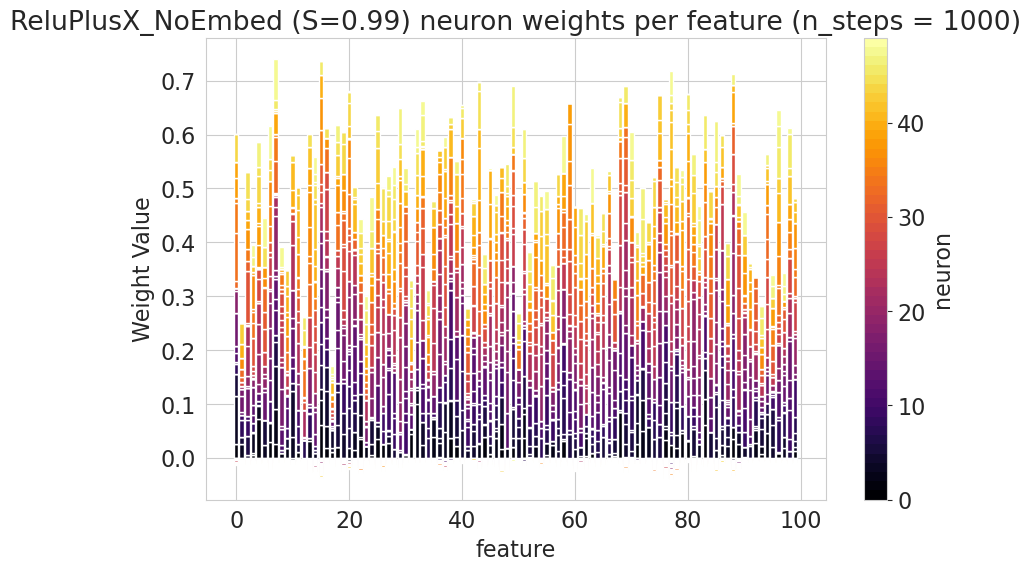

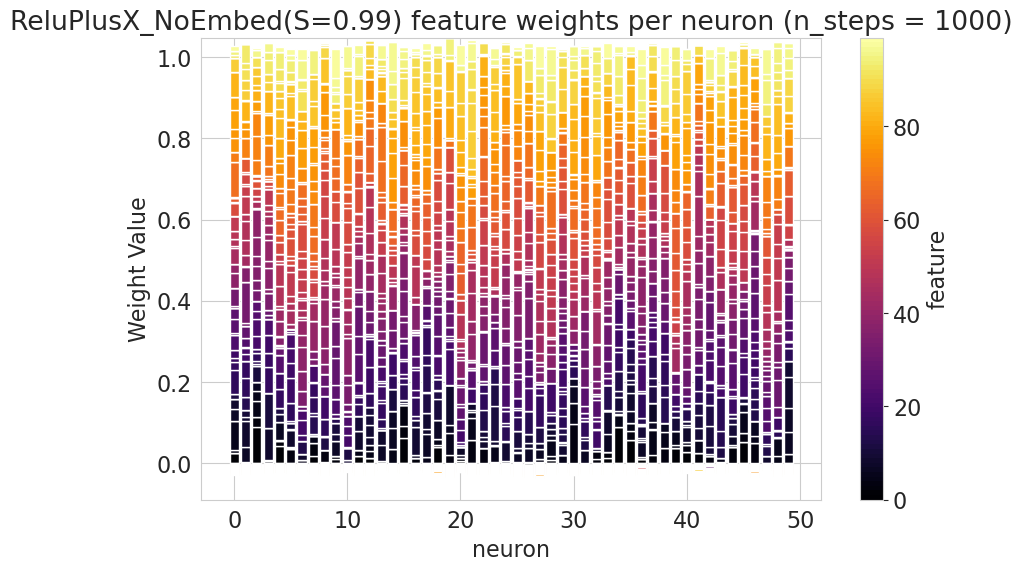

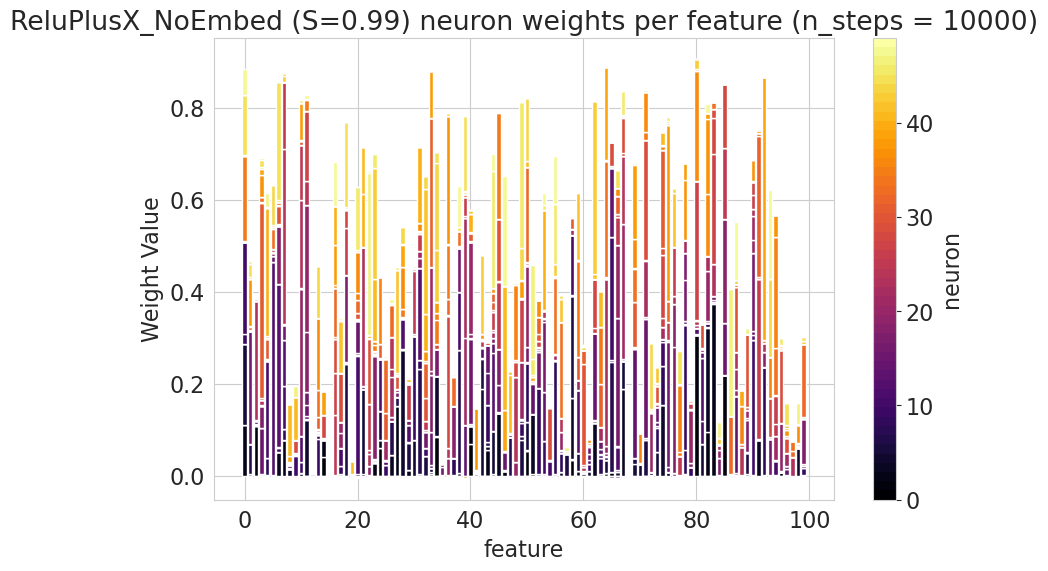

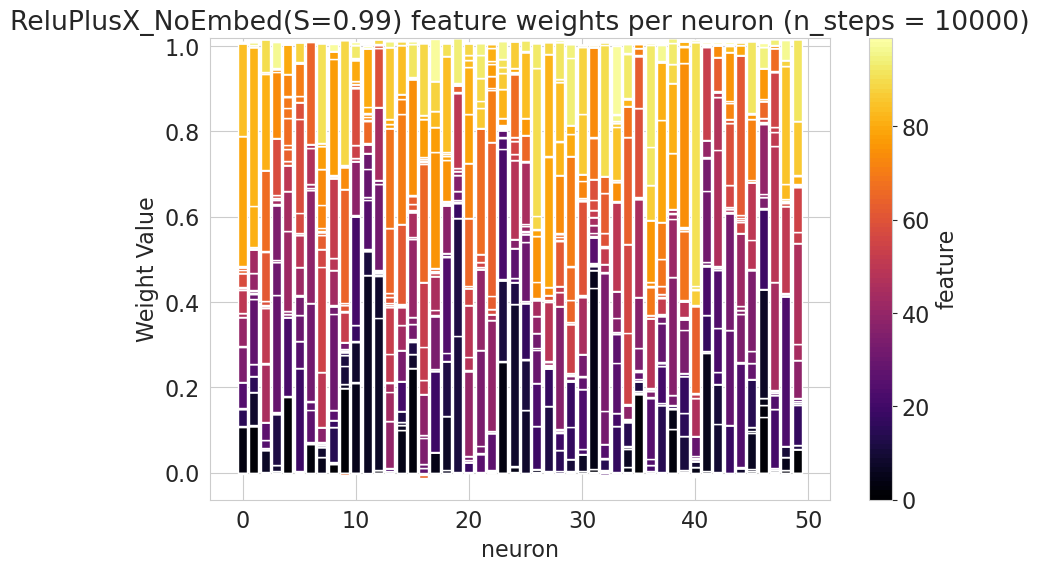

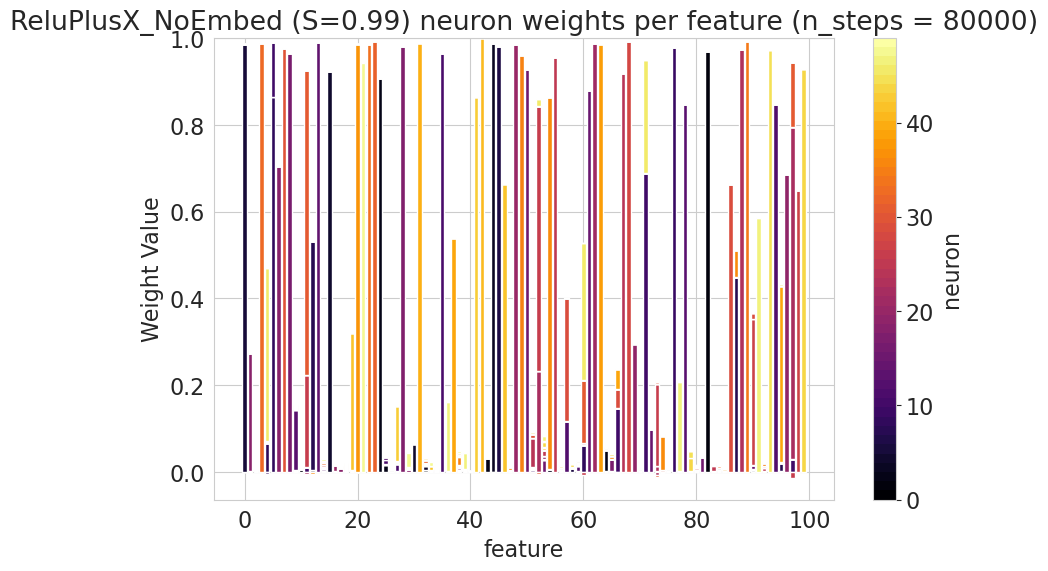

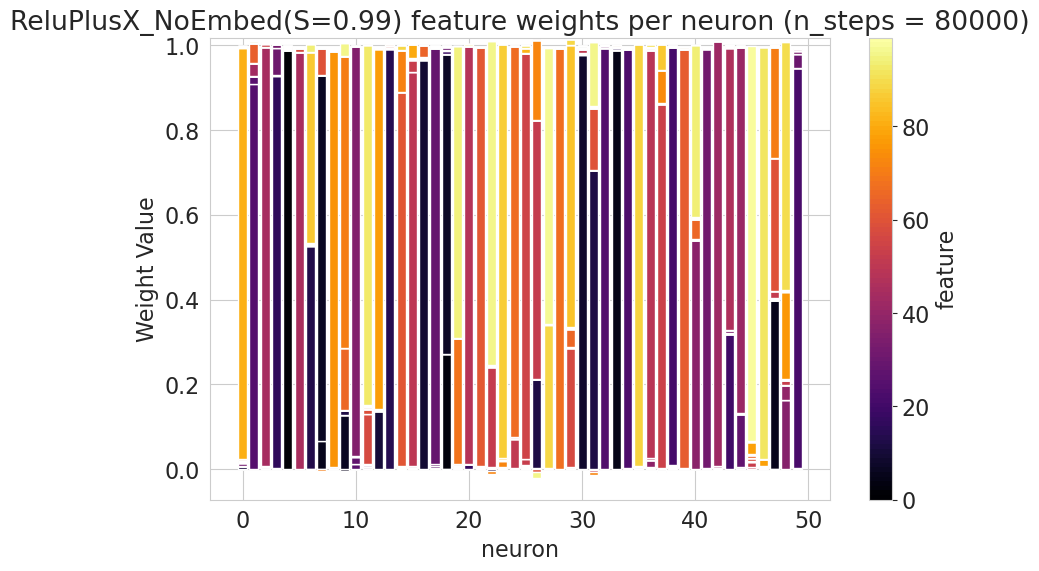

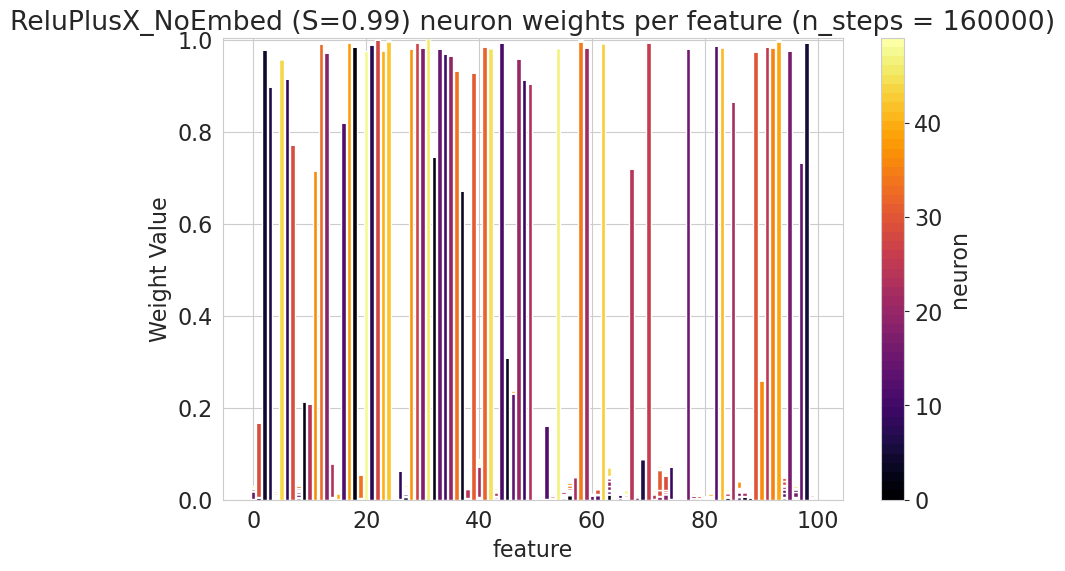

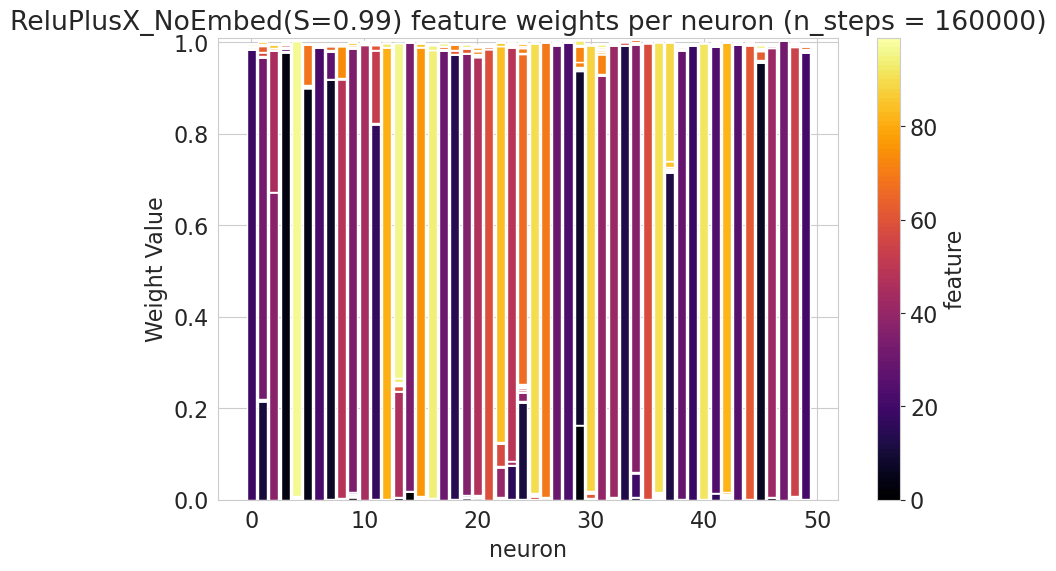

In [6]:
"""Create and train model."""

layer_act_fns = [t.relu, lambda x: x]

reluPlusX_res_noEmbed_cfg = CisConfig(
    n_instances=1,
    n_feat=100,
    n_hidden=50,
    act_fn=layer_act_fns,
    b1=None,
    b2=None,
    skip_cnx=True,
    We_and_Wu=False,
)

loss_data_ReluPlus_NoEmbed99 = []
poly_data_ReluPlus_NoEmbed99 = []
steps_list = [1000, 10000, 80000, 160000]

for n_steps in steps_list: 

    if 'reluPlusX_res_noEmbed_cis' in locals() or 'reluPlusX_res_noEmbed_cis' in globals():
        del reluPlusX_res_noEmbed_cis
        
    reluPlusX_res_noEmbed_cis = Cis(reluPlusX_res_noEmbed_cfg, device=device).to(device)

    batch_sz = 256
    feat_sparsity = 0.99
    feat_importance = 1
    logging_freq = n_steps // 10
    optimizer = t.optim.Adam(reluPlusX_res_noEmbed_cis.parameters())
    
    losses = train(
        reluPlusX_res_noEmbed_cis,
        batch_sz,
        feat_sparsity,
        feat_importance,
        loss_fn,
        optimizer,
        n_steps,
        logging_freq
    )
    display(losses)

    # 2. Test performance at different sparsity levels
    sparsities = [0.2, 0.4, 0.6, 0.8, 0.9, 0.99]
    batch_sz = 256
    feat_importance = 1
    logging_freq = n_steps // 10
    
    pbar = tqdm(sparsities, desc="Testing over sparsities")
    n_examples = 200
    
    for s in pbar:
        
        with t.no_grad():
            # generate examples of inputs
            x, y_true = gen_batch(reluPlusX_res_noEmbed_cis, n_examples, s)
            
            # compute mean loss
            y = reluPlusX_res_noEmbed_cis.forward(x)
            active_weight, inactive_weight = 10, 1
            weights = t.where(y_true == 1, active_weight, inactive_weight)
            loss = weights * (y - y_true) ** 2
            
            # store loss at sparsity level
            loss = rearrange(loss, "examples 1 features -> examples features")
            loss = asnumpy(reduce(loss, "examples features -> features", "mean"))
            for feat_idx, val in enumerate(loss):
                loss_data_ReluPlus_NoEmbed99.append({"steps": n_steps, "sparsity": s, "feature_idx": feat_idx, "loss_per_feature": val})

    # 3. Plot weights per neuron and per feature
    """Plot weights for neurons per feature, and for features per neuron."""

    W = einsum(reluPlusX_res_noEmbed_cis.W1, reluPlusX_res_noEmbed_cis.W2, "inst neuron feature, inst feature neuron-> neuron feature")
    W = threshold_matrix(W.squeeze(), threshold=0.001)
    
    print(f"{W.shape=}")
    
    fig = plot_weight_bars(W, xax="feature")
    fig.get_axes()[0].set_title(r"ReluPlusX_NoEmbed (S=0.99) neuron weights per feature (n_steps = {})".format(n_steps))
    fig.savefig(f"/workspace/S=099ReluPlusX_NoEmbed_weightsPerFeature_nSteps{n_steps}.png", dpi = 300)
    
    fig = plot_weight_bars(W.T, xax="neuron")
    fig.get_axes()[0].set_title(r"ReluPlusX_NoEmbed(S=0.99) feature weights per neuron (n_steps = {})".format(n_steps))
    fig.savefig(f"/workspace/S=099ReluPlusX_NoEmbed_weightsPerNeuron_nSteps{n_steps}.png", dpi = 300)

    # 4. Compute number of features per neuron and number of monosemantic neurons and store
    features_per_neuron = np.sum(W.cpu().detach().numpy() > 0.001, axis= 1)
    monosemantic_neurons = np.sum(features_per_neuron == 1)
    poly_data_ReluPlus_NoEmbed99.append({"steps": n_steps, "features_per_neuron": features_per_neuron, "monosemantic_neurons": monosemantic_neurons})
    

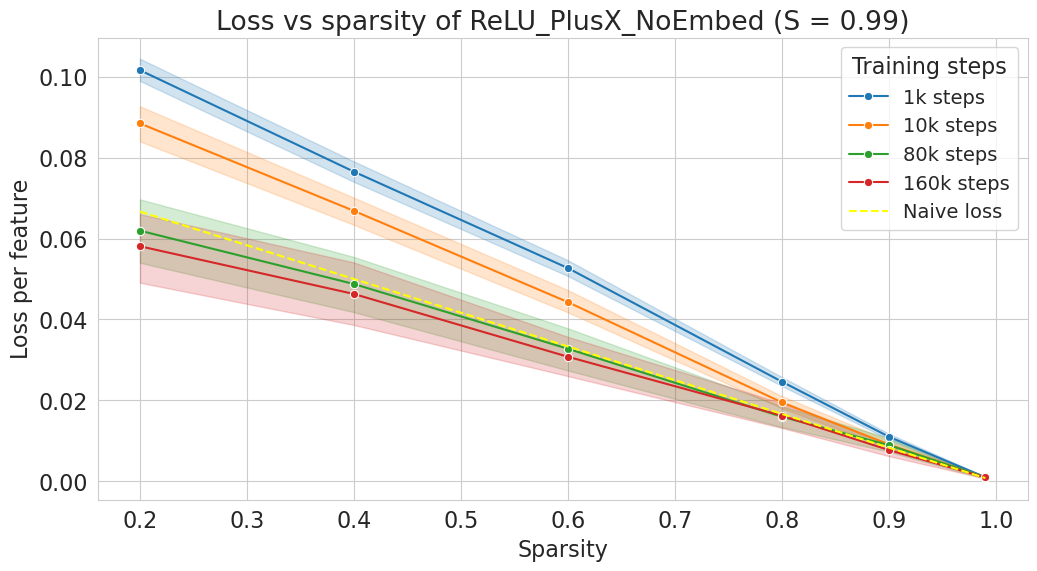

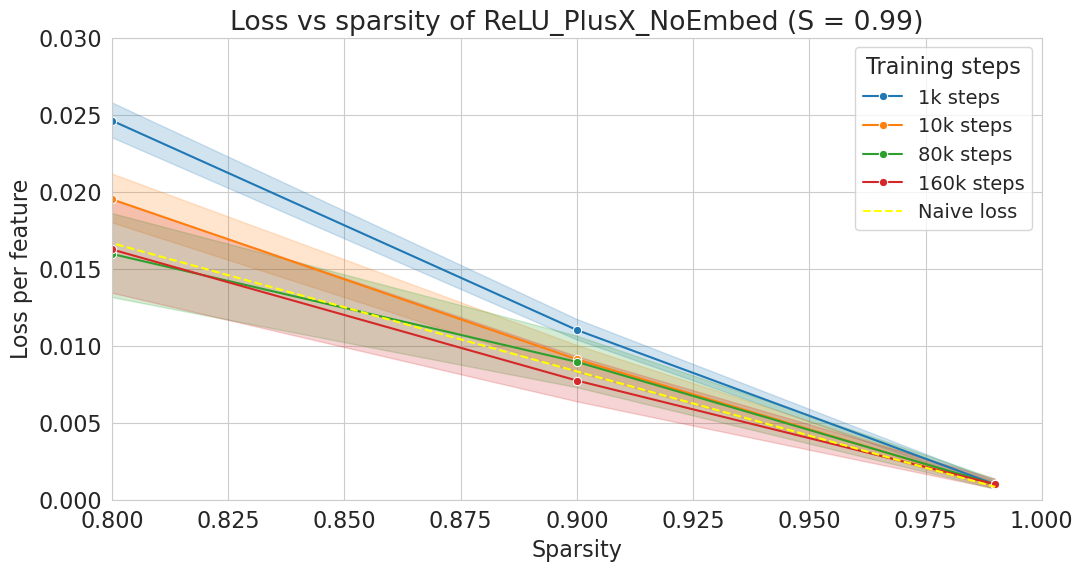

In [7]:
## Plot performance at various sparsity levels vs number of steps during training

df = pd.DataFrame.from_dict(loss_data_ReluPlus_NoEmbed99, orient="columns")
dfs = {group: df[df["steps"] == group].drop(columns="steps") for group in df["steps"]}

df_1k = dfs[1000]
df_10k = dfs[10000]
df_80k = dfs[80000]
df_160k = dfs[160000]

# Add a column to track the origin of each DataFrame
df_1k['source'] = '1k steps'
df_10k['source'] = '10k steps'
df_80k['source'] = '80k steps'
df_160k['source'] = '160k steps'

# Combine all DataFrames
df_combined = pd.concat([df_1k, df_10k, df_80k, df_160k])

# Plot
plt.figure(figsize=(12, 6))
sns.lineplot(data=df_combined, x='sparsity', y = "loss_per_feature", hue='source', marker='o')

# add naive loss
naive_loss = 0.5 * (1 - np.array(sparsities)) / 6
plt.plot(sparsities, naive_loss.ravel(), linestyle="dashed", color="yellow", label=r"Naive loss")

# Customize legend
plt.legend(title="Training steps", fontsize = 14)

# Labels & Title
plt.xlabel("Sparsity")
plt.ylabel("Loss per feature")
plt.title("Loss vs sparsity of ReLU_PlusX_NoEmbed (S = 0.99)")

# Save and show plot
plt.savefig("/workspace/ReluPlusNoEmbed_S=099_loss_numberSteps.png", dpi=300)
plt.show()

# Plot
plt.figure(figsize=(12, 6))
sns.lineplot(data=df_combined, x='sparsity', y = "loss_per_feature", hue='source', marker='o')

# add naive loss
naive_loss = 0.5 * (1 - np.array(sparsities)) / 6
plt.plot(sparsities, naive_loss.ravel(), linestyle="dashed", color="yellow", label=r"Naive loss")

# Customize legend
plt.legend(title="Training steps", fontsize = 14)

# Labels & Title
plt.xlim(0.8,1.0)
plt.ylim(0,0.03)
plt.xlabel("Sparsity")
plt.ylabel("Loss per feature")
plt.title("Loss vs sparsity of ReLU_PlusX_NoEmbed (S = 0.99)")

# Save and show plot
plt.savefig("/workspace/ReluPlusNoEmbed_S=099_loss_numberSteps_highS.png", dpi=300)
plt.show()

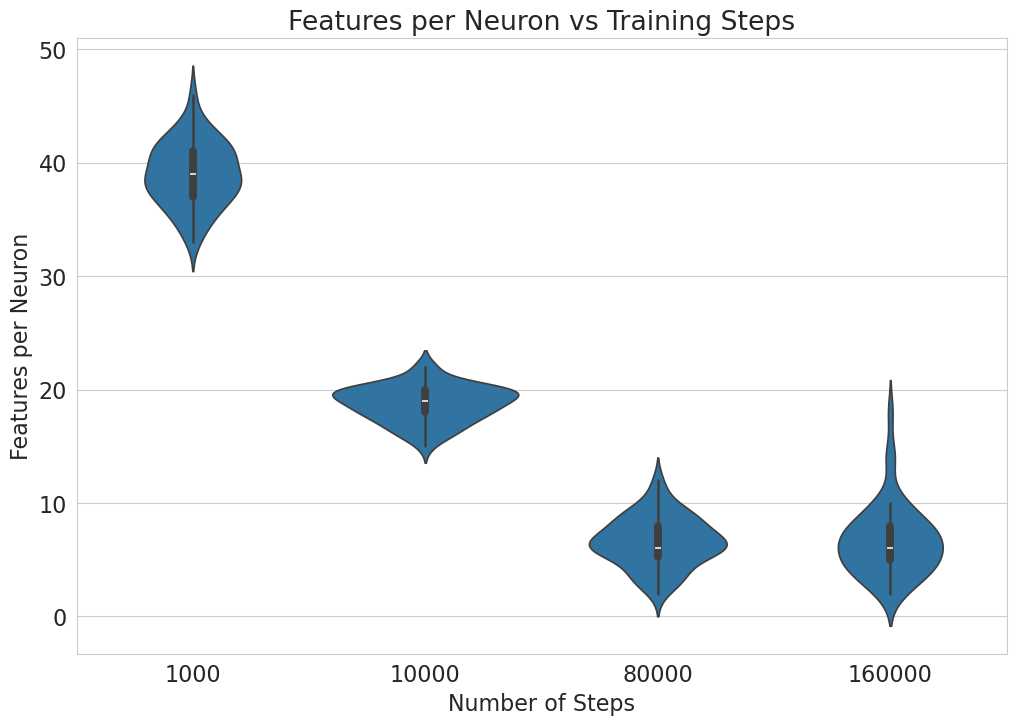

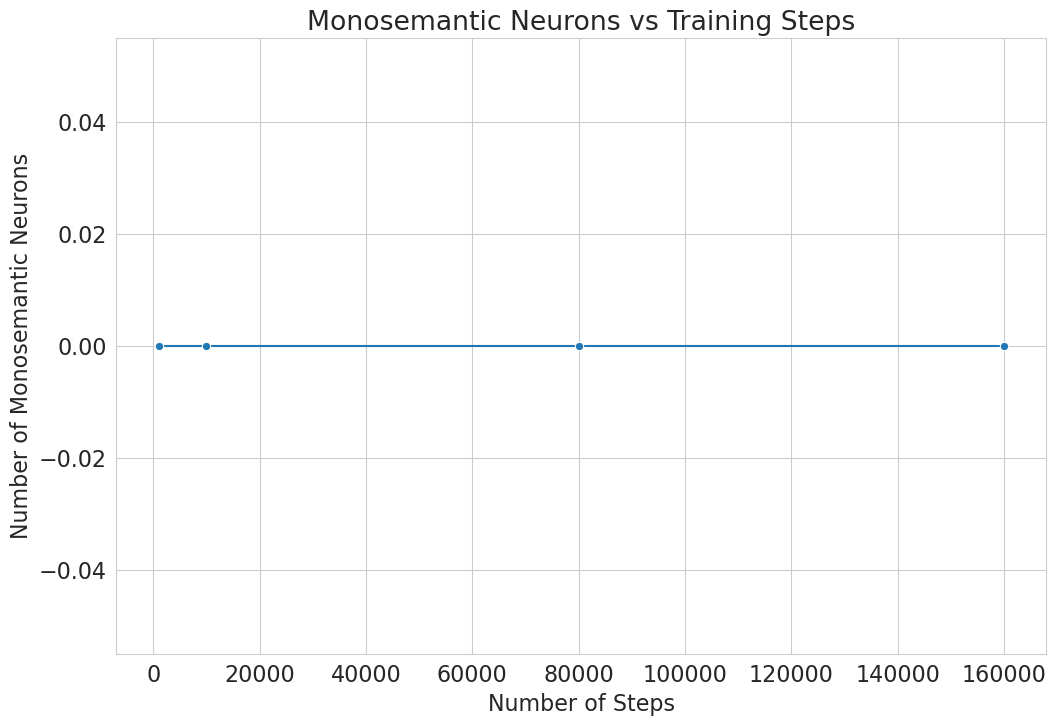

In [26]:
# Plot feature per neuron and number of monosemantic neurons across training steps

poly_data = pd.DataFrame(poly_data_ReluPlus_NoEmbed99)

# Expand lists into separate rows, replicating 'steps' for each
poly_data_df = poly_data.explode("features_per_neuron")

# Convert 'features_per_neuron' to float
poly_data_df["features_per_neuron"] = poly_data_df["features_per_neuron"].astype(float)

plt.figure(figsize=(12,8))
sns.violinplot(data=poly_data_df, x="steps", y="features_per_neuron")

# Labels and title
plt.xlabel("Number of Steps")
plt.ylabel("Features per Neuron")
plt.title("Features per Neuron vs Training Steps")

plt.savefig("/workspace/ReLUplusNoEmbedS=099_featuresPerNeuron_trainingSteps.png", dpi=300)
plt.show()

# Expand lists into separate rows, replicating 'steps' for each
poly_data_df = poly_data.explode("monosemantic_neurons")

# Convert 'features_per_neuron' to float
poly_data_df["monosemantic_neurons"] = poly_data_df["monosemantic_neurons"].astype(float)

plt.figure(figsize=(12,8))
sns.lineplot(data=poly_data, x="steps", y="monosemantic_neurons", marker="o")

# Labels and title
plt.xlabel("Number of Steps")
plt.ylabel("Number of Monosemantic Neurons")
plt.title("Monosemantic Neurons vs Training Steps")

plt.savefig("/workspace/ReLUplusNoEmbedS=099_monosemanticNeurons_trainingSteps.png", dpi=300)
plt.show()

In [14]:
print('for 1k steps, at S =0.99 mean loss = ', df_1k[df_1k['sparsity'] == 0.99]['loss_per_feature'].mean(),
    ' and std = ', df_1k[df_1k['sparsity'] == 0.99]['loss_per_feature'].std())
print('for 10k steps, at S =0.99 mean loss = ', df_10k[df_10k['sparsity'] == 0.99]['loss_per_feature'].mean(),
    ' and std = ', df_10k[df_10k['sparsity'] == 0.99]['loss_per_feature'].std())
print('for 80k steps, at S =0.99 mean loss = ', df_80k[df_80k['sparsity'] == 0.99]['loss_per_feature'].mean(),
    ' and std = ', df_80k[df_80k['sparsity'] == 0.99]['loss_per_feature'].std())
print('for 160k steps, at S =0.99 mean loss = ', df_160k[df_160k['sparsity'] == 0.99]['loss_per_feature'].mean(),
    ' and std = ', df_160k[df_160k['sparsity'] == 0.99]['loss_per_feature'].std())

for 1k steps, at S =0.99 mean loss =  0.0009929305  and std =  0.0009731618
for 10k steps, at S =0.99 mean loss =  0.00093024987  and std =  0.0010360928
for 80k steps, at S =0.99 mean loss =  0.0009903  and std =  0.001743385
for 160k steps, at S =0.99 mean loss =  0.0010049441  and std =  0.0016339988


In [ ]:
print(poly_data["monosemantic_neurons"])